> # Report Goal

The goal of this report is to analyze a dataset consisting of information from credit facility dataset (18769 records) and to comprehend which factors impact the Credit Card cardholder spending power and to predict the most recent month billable amount (B1) of a given individual . this project could be conducted as part of a customer analysis for the credit provider.

For this project, a multivariable regression analysis will be used. The report will begin with an exploratory data analysis of the dataset, followed by data cleaning, visualisation and linear regression analysis. At the end, the regression model created will be deployed to simulate the testing dataset and predict the B1 of cardholders given their background information.


> # Project set-up

# 0. Import the necessary libraries

In [30]:
!pip install PyYAML

In [31]:
!pip install shap

In [32]:
!pip install yellowbrick

In [33]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
# from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy import stats
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

col_list = ['#005f9a', '#00CDCD', '#f1bdbf']
sns.set_palette(col_list)

In [34]:
df_original = pd.read_csv("./ECA_data.csv", index_col=0)
df_original.head()

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
ID,,,,,,,,,,,,,,,,,,,,,
1,210000,0.00,235822,1,1,1.0,2.0,30,0,0,...,0,0,0,0,0,0,0,0,0,0
2,260000,10928.05,278481,0,0,2.0,2.0,31,0,0,...,54074,46407,38874,31324,24031,2000,2000,2000,2000,72000
3,400000,65397.85,431993,0,0,3.0,1.0,51,0,0,...,343591,352484,338823,283288,185288,15000,14000,11500,8000,7000
4,20000,3695.30,22368,0,0,2.0,1.0,58,-1,2,...,21470,200,0,28740,1295,0,0,28740,1565,0
5,180000,68.25,166900,0,1,2.0,1.0,42,0,0,...,1260,598,2056,4300,1802,598,2056,4300,1802,3691


In [35]:
df_original_copy = df_original.copy()

In [36]:
df_original_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18769 entries, 1 to 18766
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT      18769 non-null  int64  
 1   BALANCE    18769 non-null  float64
 2   INCOME     18769 non-null  int64  
 3   RATING     18769 non-null  int64  
 4   GENDER     18769 non-null  int64  
 5   EDUCATION  18756 non-null  float64
 6   MARITAL    18731 non-null  float64
 7   AGE        18769 non-null  int64  
 8   S1         18769 non-null  int64  
 9   S2         18769 non-null  int64  
 10  S3         18769 non-null  int64  
 11  S4         18769 non-null  int64  
 12  S5         18769 non-null  int64  
 13  B1         18769 non-null  int64  
 14  B2         18769 non-null  int64  
 15  B3         18769 non-null  int64  
 16  B4         18769 non-null  int64  
 17  B5         18769 non-null  int64  
 18  R1         18769 non-null  int64  
 19  R2         18769 non-null  int64  
 20  R3    

> # Question 1
> ###### List the categorical and numeric variables

# 1. List the categorical and numeric variables

In [37]:
# List the categorical variables
df_categorical = df_original_copy [["RATING","GENDER","EDUCATION","MARITAL"]]
print(list(df_categorical.columns))

['RATING', 'GENDER', 'EDUCATION', 'MARITAL']


In [38]:
# List the numberic variables
df_numberic = df_original_copy.drop(columns=["RATING","GENDER","EDUCATION","MARITAL"])
print(list(df_numberic.columns))

['LIMIT', 'BALANCE', 'INCOME', 'AGE', 'S1', 'S2', 'S3', 'S4', 'S5', 'B1', 'B2', 'B3', 'B4', 'B5', 'R1', 'R2', 'R3', 'R4', 'R5']


> # Question 2
> ###### Data pre-processing


RATING:
- Filling numeric values with descriptive value [ rating (0: Good, 1: Bad) ]

GENDER
- Filling numeric values with descriptive value [ gender (0: Male, 1: Female) ]

EDUCATION:
- Missing value(Replace with the mode)
- Filling numeric values with descriptive value [ Customer highest education attained (0: Others, 1: Postgraduate, 2: Tertiary, 3: High School) ]

MARITAL:
- Missing value(Replace with the mode)
- Filling numberic values with descriptive value [ marital status (0: Others, 1: Single, 2: Married) ]

LIMIT
- Outliers handler

BALANCE
- Outliers handler

INCOME
- Outliers handler

AGE
- Outliers handler

## 2.1 Handling Missing Values

In [39]:
# Identify the missing values
df_original_copy.isnull().sum()

LIMIT         0
BALANCE       0
INCOME        0
RATING        0
GENDER        0
EDUCATION    13
MARITAL      38
AGE           0
S1            0
S2            0
S3            0
S4            0
S5            0
B1            0
B2            0
B3            0
B4            0
B5            0
R1            0
R2            0
R3            0
R4            0
R5            0
dtype: int64

In [40]:
# Missing values imputer
class MissingValueImputer(BaseEstimator , TransformerMixin):
    def __init__(self, mode_imputed_ft = ['RATING', 'GENDER', 'EDUCATION', 'MARITAL'], median_imputed_ft = ['LIMIT', 'BALANCE', 'INCOME', 'AGE']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


def pipeline_MissingValueImputer(df):
    pipeline = Pipeline([
        ('missing value imputer', MissingValueImputer()),
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [41]:
pd.options.mode.chained_assignment = None
df_original_copy_prep = pipeline_MissingValueImputer(df_original_copy)

**Comment**
- missing values in 'EDUCATION', 'MARITAL' are replaced with mode, which makes the dataset more reasonable and improve the prediction accuracy.

## 2.2 Decode by filling numberic values with descriptive value

In [42]:
# decode the selected columns by filling numeric values with descriptive value
df_original_copy_prep = df_original_copy_prep.astype({"EDUCATION":'int', "MARITAL":'int'}) # converting 'EDUCATION' and 'MARITAL' from float to int
name_dict = {"GENDER" : {0:"Male", 1:"Female"},
             "RATING" : {0:"Good", 1:"Bad"},
             "EDUCATION" : {0: "Others", 1: "Postgraduate", 2: "Tertiary", 3: "High School"},
             "MARITAL" : {0: "Others", 1:"Single", 2:"Married"}}

for column in name_dict.keys():
    df_original_copy_prep[column] = df_original_copy_prep[column].apply(lambda x : name_dict[column][x])

df_original_copy_prep.head()

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
ID,,,,,,,,,,,,,,,,,,,,,
1,210000,0.00,235822,Bad,Female,Postgraduate,Married,30,0,0,...,0,0,0,0,0,0,0,0,0,0
2,260000,10928.05,278481,Good,Male,Tertiary,Married,31,0,0,...,54074,46407,38874,31324,24031,2000,2000,2000,2000,72000
3,400000,65397.85,431993,Good,Male,High School,Single,51,0,0,...,343591,352484,338823,283288,185288,15000,14000,11500,8000,7000
4,20000,3695.30,22368,Good,Male,Tertiary,Single,58,-1,2,...,21470,200,0,28740,1295,0,0,28740,1565,0
5,180000,68.25,166900,Good,Female,Tertiary,Single,42,0,0,...,1260,598,2056,4300,1802,598,2056,4300,1802,3691


**Comment**
- Based on the case background, decode the selected columns by filling numeric values with descriptive value
- The handled data will be used for further data visualisation

## 2.3 Set categorical variables

In [43]:
df_original_copy_prep.RATING = df_original_copy_prep.RATING.astype('category')
df_original_copy_prep.GENDER = df_original_copy_prep.GENDER.astype('category')
df_original_copy_prep.EDUCATION = df_original_copy_prep.EDUCATION.astype('category')
df_original_copy_prep.MARITAL = df_original_copy_prep.MARITAL.astype('category')

In [44]:
df_original_copy_prep.describe(include=['category'])

,RATING,GENDER,EDUCATION,MARITAL
count,18769,18769,18769,18769
unique,2,2,4,3
top,Good,Female,Tertiary,Married
freq,14654,11605,8885,9872


In [45]:
df_original_copy_prep.dtypes

LIMIT           int64
BALANCE       float64
INCOME          int64
RATING       category
GENDER       category
EDUCATION    category
MARITAL      category
AGE             int64
S1              int64
S2              int64
S3              int64
S4              int64
S5              int64
B1              int64
B2              int64
B3              int64
B4              int64
B5              int64
R1              int64
R2              int64
R3             object
R4              int64
R5              int64
dtype: object

**Comment**
- 'RATING', 'GENDER', 'EDUCATION', 'MARITAL' are set as "categorical" variables for further data visualisation on categoryical studys, e.g. correlation

## 2.4 Detect and Handle Outliers

#### 2.4.1 Outlier Detection for Numeric Variables

KeyError: 0

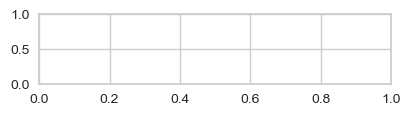

In [47]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(['LIMIT', 'BALANCE', 'INCOME','AGE','B1','B2','B3','B4','B5','R1','R2','R3','R4','R5']):
    plt.subplot(6, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.boxplot(df_original_copy_prep[j])
    plt.tight_layout()

#### 2.4.2 Outliers imputer

In [48]:
# 2.4.1 Outliers imputer
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['LIMIT', 'BALANCE', 'INCOME', 'AGE','B1','B2','B3','B4','B5','R1','R2','R3','R4','R5']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

def pipeline_outlierImputer(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [49]:
pd.options.mode.chained_assignment = None
df_original_copy_prep = pipeline_outlierImputer(df_original_copy_prep)

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


**Comment**
- Previously, outliers are detected in 'LIMIT', 'BALANCE', 'INCOME', 'AGE'.
- Handled the outliers for further data clean steps.

> # Question 3
> ###### Insights of the data with visualization

## 3.1 Studying the target of inference

Fristly, let's scan the target of inference ( B1 ) in isolation.



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot:xlabel='B1', ylabel='Density'>

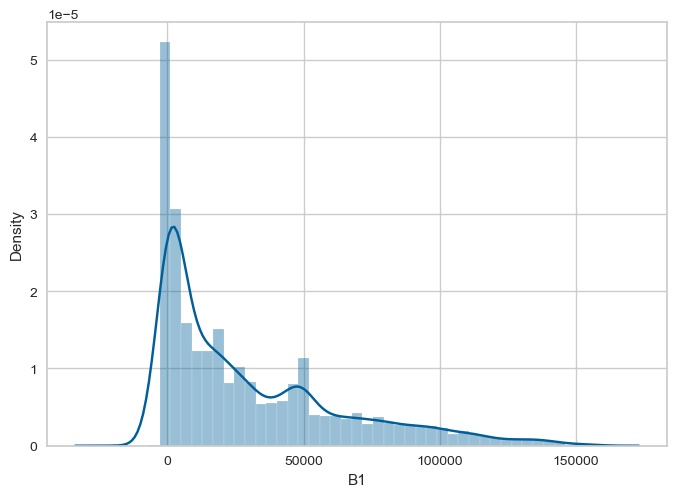

In [50]:
sns.distplot(df_original_copy_prep.B1)

It can be noticed that a large portion of the sample consists of Zero billable amount. Therefore, We have quite a number of inacitve credit card users.

This is an important distinction because, if the average billable amount in the most recent month for a given individual is zero, we conclude that the person does not make use of that credit card. As a credit provider, we may be interested in knowing the average payable amount across our active users (for instance, to identify those at risk of default), and the zero B1 may skew our results.

We can create an additional data frame which only contains the observations with a positive billable amount ( B1 ).

In [51]:
active_df = df_original_copy_prep.loc[df_original_copy_prep.B1>0,].copy()
active_df.B1.describe()

count     11413.000000
mean      34208.089284
std       34130.538137
min           3.000000
25%        5830.000000
50%       22699.000000
75%       50774.000000
max      157941.000000
Name: B1, dtype: float64

## 3.2 examine the categorical variables and their relationship to the most recent billable amount B1.

MARITAL
Married    AxesSubplot(0.555556,0.11;0.344444x0.334783)
Others     AxesSubplot(0.555556,0.11;0.344444x0.334783)
Single     AxesSubplot(0.555556,0.11;0.344444x0.334783)
Name: B1, dtype: object

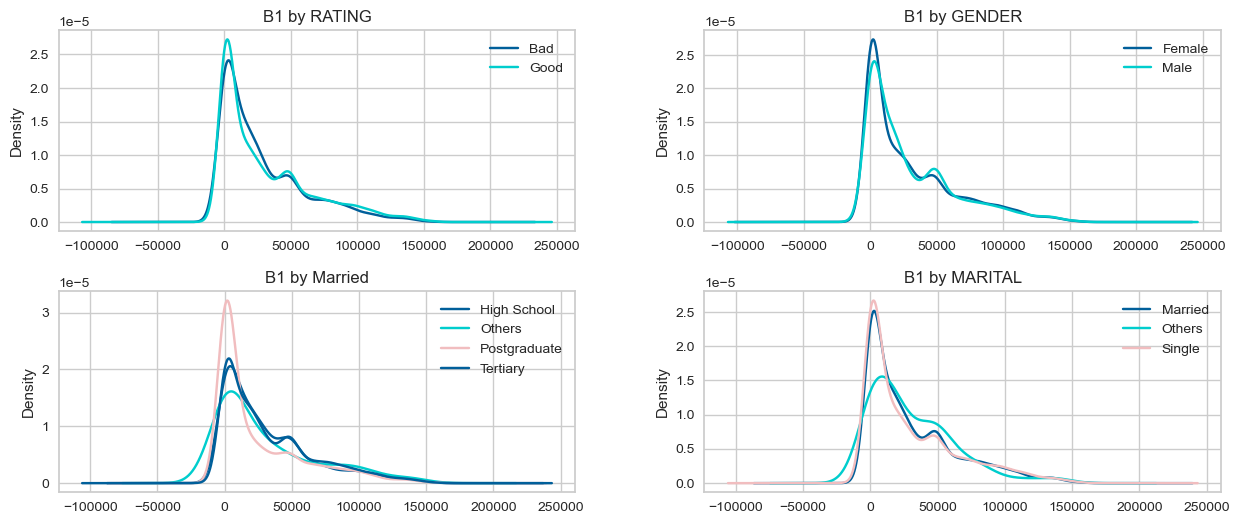

In [52]:
f, axes = plt.subplots(2, 2, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
df_original_copy_prep.groupby('RATING').B1.plot(kind='kde', ax=axes[0][0], legend=True, title='B1 by RATING')
df_original_copy_prep.groupby('GENDER').B1.plot(kind='kde', ax=axes[0][1], legend=True, title='B1 by GENDER')
df_original_copy_prep.groupby('EDUCATION').B1.plot(kind='kde', ax=axes[1][0], legend=True, title='B1 by Married')
df_original_copy_prep.groupby('MARITAL').B1.plot(kind='kde', ax=axes[1][1], legend=True, title='B1 by MARITAL')

No indicator appears to influence the distribution of B1 significantly. To verify, the same relationships can be analyzed on the active-only dataset of the population.

MARITAL
Married    AxesSubplot(0.555556,0.11;0.344444x0.334783)
Others     AxesSubplot(0.555556,0.11;0.344444x0.334783)
Single     AxesSubplot(0.555556,0.11;0.344444x0.334783)
Name: B1, dtype: object

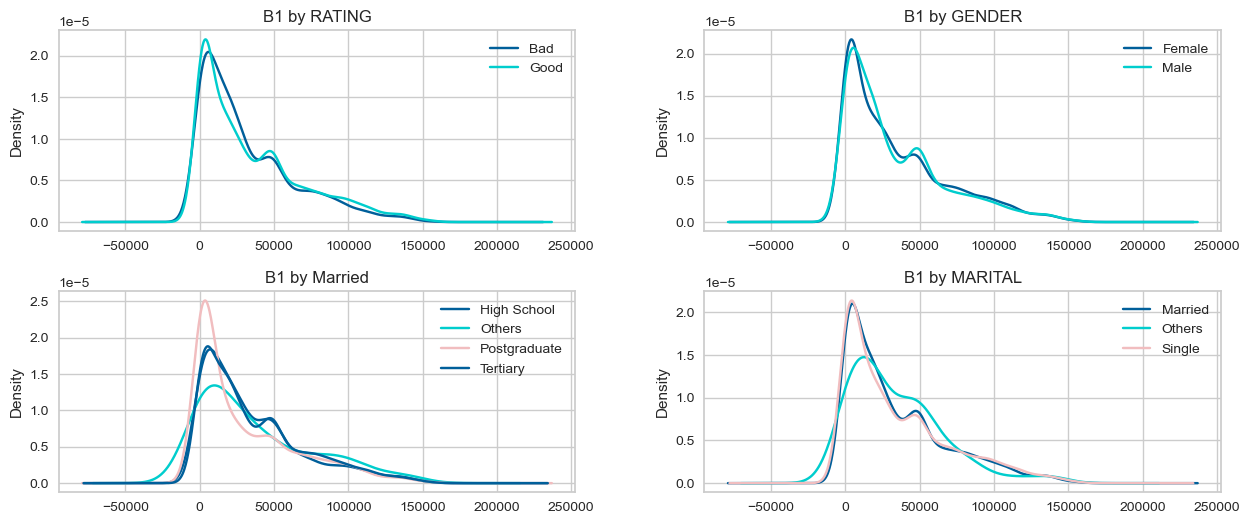

In [53]:
f, axes = plt.subplots(2, 2, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
active_df.groupby('RATING').B1.plot(kind='kde', ax=axes[0][0], legend=True, title='B1 by RATING')
active_df.groupby('GENDER').B1.plot(kind='kde', ax=axes[0][1], legend=True, title='B1 by GENDER')
active_df.groupby('EDUCATION').B1.plot(kind='kde', ax=axes[1][0], legend=True, title='B1 by Married')
active_df.groupby('MARITAL').B1.plot(kind='kde', ax=axes[1][1], legend=True, title='B1 by MARITAL')

Although the variables RATING, GENDER, EDUCATION and MARITAL do not appear associated with B1 when observed in isolation, their interaction with one another might make them useful to this study. This will be investigated at a later point in the analysis.

## 3.3 exlpore the income relationship with the most recent billable amount B1.

In [54]:
sns.regplot('B1', 'INCOME',
            data = df_original_copy_prep,
            ci=None,
            order=2,
            line_kws={'color':'black'})

TypeError: regplot() got multiple values for argument 'data'

As anticipated, at lower levels of Income, increases in personal Income cause a decrease in B1, which can be interpreted as people requiring less financing as they make use of personal finances instead of credit debt.

On the other side, at higher levels of income, B1 increases, meaning that those customers are in higher need of loans, potentially due to increased investment activities and a greater risk tolerance.

## 3.4 Bivariate Analysis

In [ ]:
df_original_copy_prep = df_original_copy_prep.reset_index()

In [ ]:
df_original_copy_prep.head()

#### 3.5.1 Scatter plots

In [ ]:
sns.pairplot(df_original_copy_prep.drop(['ID','RATING','GENDER','EDUCATION','MARITAL'],axis=1),corner=True)
plt.show()

## 3.5 Scatter plots

##### 3.5.1. INCOME vs LIMIT

In [ ]:
sns.regplot(x='INCOME',y='LIMIT',data=df_original_copy_prep,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

##### 3.5.2 BALANCE vs B1

In [ ]:
sns.regplot(x='BALANCE',y='B1',data=df_original_copy_prep,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

##### 3.5.3 R1 vs B1

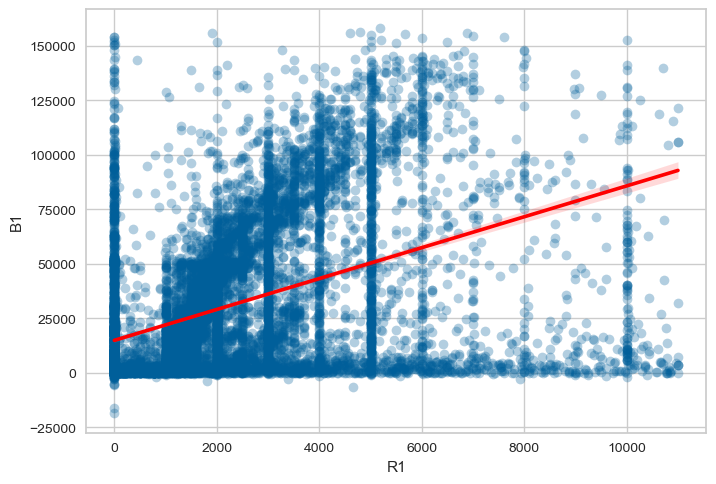

In [55]:
sns.regplot(x='R1',y='B1',data=df_original_copy_prep,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Limit is highly correlated with income
- Balance is highly correlated with billable amount - B(n)
- previous repayment amount R(n) is correlated with billable amount - B(n)

> # Question 4
> ###### linear regression modelling to predict the variable, B1

## 4.1 Data Preprocessing

### 4.1.1 Feature drop

In [56]:
df_original_copy_prep.head()

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
ID,,,,,,,,,,,,,,,,,,,,,
1,210000,0.00,235822,Bad,Female,Postgraduate,Married,30,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20000,3695.30,22368,Good,Male,Tertiary,Single,58,-1,2,...,21470,200,0,28740,1295,0,0,28740,1565,0
5,180000,68.25,166900,Good,Female,Tertiary,Single,42,0,0,...,1260,598,2056,4300,1802,598,2056,4300,1802,3691
7,30000,4950.75,23160,Good,Male,High School,Married,44,2,2,...,30728,29701,29121,29715,0,0,600,594,0,0
8,50000,7139.65,56265,Good,Female,Tertiary,Single,34,0,0,...,38937,34737,18702,15604,16333,2000,1000,578,1000,1000


In [57]:
df = df_original_copy_prep.drop('ID', axis=1)
df.head()

KeyError: "['ID'] not found in axis"

### 4.1.2 Splitting the data and Scaling

After examining the predictors and their relationship with B1, regression models can be fit using those predictors. Given the choice of 17 predictors, the initial model could cover all of them. Yet, due to potential collinearity issues, 'S1', 'B1','R1' will be eliminated.

The Ordinary Least Square algorithm is used to create the linear regression model.

In [58]:
# Since cnt = casual + register, casual and register cannot be counted as predictors to prevent data leakage
X = df.drop(['S2','S3','S4', 'S5','B1','B2','B3','B4','B5','R2','R3','R4','R5'], axis=1)
y = df[['B1']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

NameError: name 'df' is not defined

In [59]:
df_train = X_train.join(y_train)
df_train.head()

NameError: name 'X_train' is not defined

In [60]:
lm0 = smf.ols('B1 ~ LIMIT + BALANCE + INCOME + RATING + GENDER + EDUCATION + MARITAL + AGE + R1 + S1', data = df_train).fit()
lm0.summary()

NameError: name 'df_train' is not defined

The model has a certain degree of fit for the Active customers dataset. This points to the hypothesis that perhaps the non-active customers are driven by some reason other than the ones present in our variables. Since they rarely make use of their credit card, it is difficult to draw conclusions. Perhaps they, in fact, have credit card debt, yet we do not have the relevant data, potentially their credit card is provided by a different company. An alternative explanation could be that the card owners maintain a zero-balance card in order to decrease their credit utilization and boost their credit rating, assuming they also own a positive balance credit card elsewhere.

It could exclude the variables which yield a high p-value from the model. Still, these variables could have an interaction with other variables and might still be significant.

Let's continue by fitting a model with only the variables that proved significant.

In [61]:
lm1 = smf.ols('B1 ~ BALANCE + EDUCATION + R1 + S1', data = df_train).fit()
lm1.summary()

NameError: name 'df_train' is not defined

We choose the variables with small P-Values, but the R-squared has, in fact, remain the same level .

The potential relationships among these 4 variables will be summarised in section 5

> ##

## 4.2 Making Predictions

Now, the model - lm1 can be used in order to predict the most recent customer billable amount (B1) of future customers given their background information. For this purpose, a dataset has been generated.

In [62]:
df_test = X_test.join(y_test)

NameError: name 'X_test' is not defined

In [63]:
df_test['B1']= lm1.predict(df_test)
df_test.describe ()

NameError: name 'lm1' is not defined

> # Question 5
> ###### linear regression equation and explain key insights

## 5.1 linear regression equation

In [64]:
# State the linear regression equation
print(lm1.params)

NameError: name 'lm1' is not defined

## 5.2 key insights

We exlpored the customer profiles - Spending Power. Since we are exploring credit related metrics. It's worth summarizing the customer file in terms of spending power.

#### 5.2.1 Spending Power - Income and Balance
  We examined the customer spending power (B1) and Income for martial groups. Since we are interested in how spending behaves.

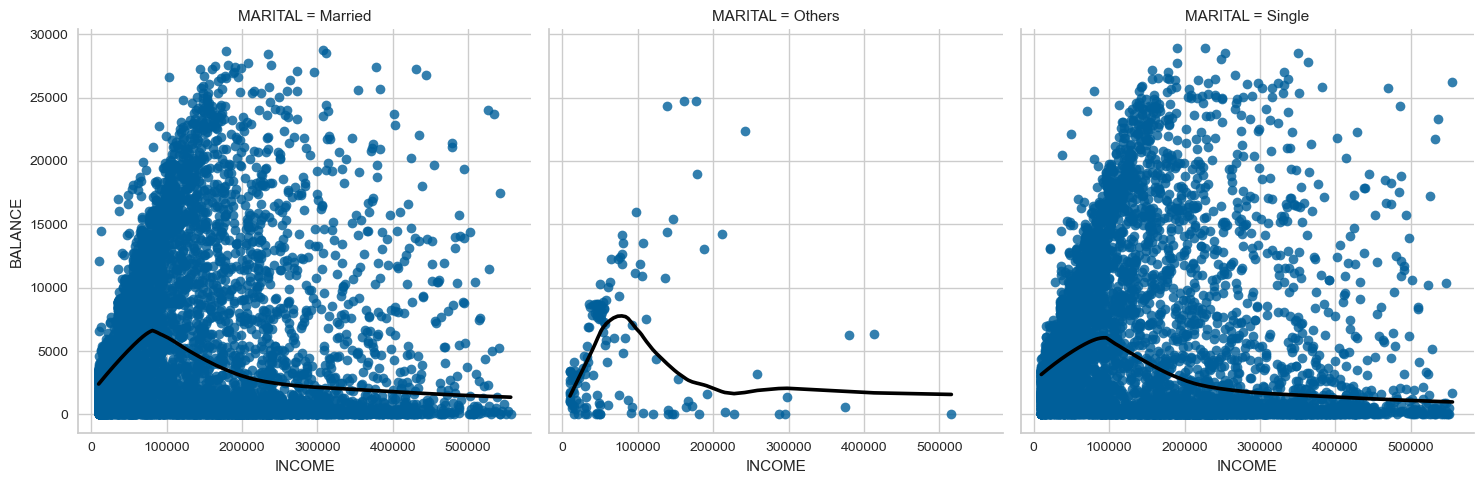

In [65]:
sns.lmplot(x='INCOME',
           y='BALANCE',
           data=df_original_copy_prep,
           line_kws={'color':'black'},
           lowess=True,
           col='MARITAL')

An interesting observation is that Income was positively related to billable amount B1 initially, but negatively realtated to B1 as income increase. This could be explained that people with higher income may have more comprehensive financial knowledge and expending plan. They normally carry more assets rather than increase their expenses. This effect appear more significant for marriged groups.

#### 5.2.2 Spending Power - exlpore the potential relationships among other variables

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


GENDER
Female    AxesSubplot(0.555556,0.11;0.344444x0.308)
Male      AxesSubplot(0.555556,0.11;0.344444x0.308)
Name: LIMIT, dtype: object

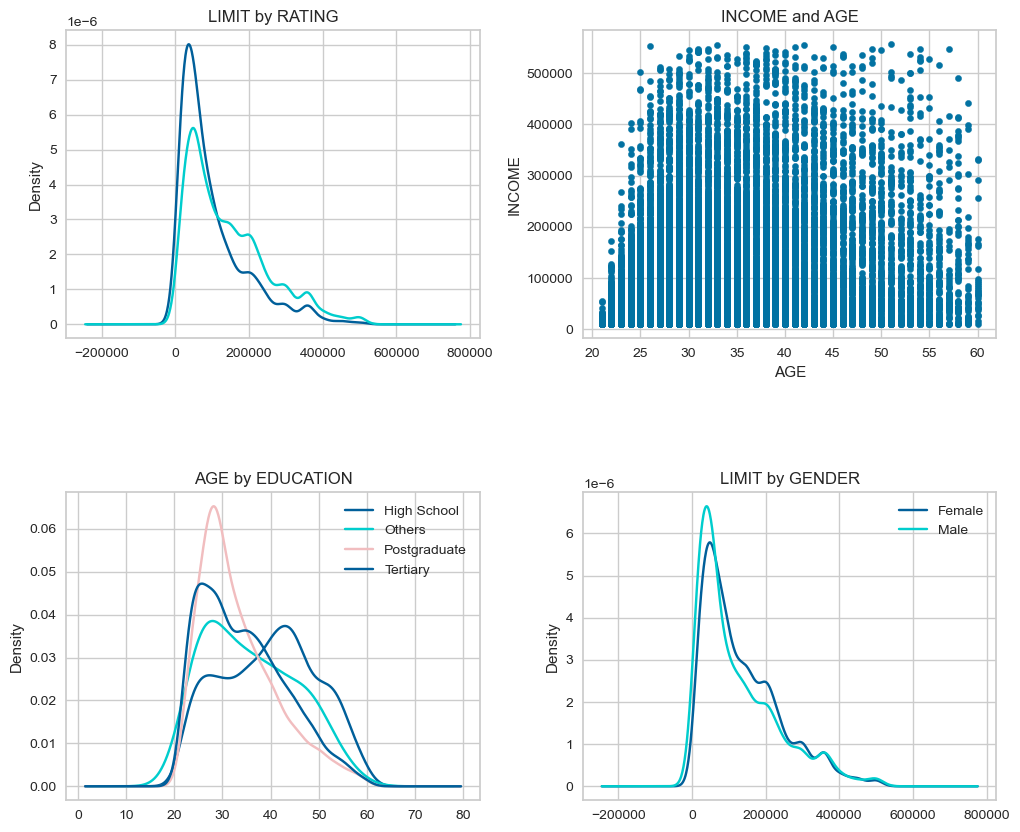

In [66]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
f.subplots_adjust(hspace=.5, wspace=.25)
df_original_copy_prep.groupby('RATING').LIMIT.plot(kind='kde', ax=axes[0][0], title='LIMIT by RATING')
df_original_copy_prep.plot(kind='scatter', x='AGE' , y='INCOME' , ax=axes[0][1], title='INCOME and AGE')
df_original_copy_prep.groupby('EDUCATION').AGE.plot(kind='kde', ax=axes[1][0], legend=True, title='AGE by EDUCATION')
df_original_copy_prep.groupby('GENDER').LIMIT.plot(kind='kde', ax=axes[1][1], legend=True, title='LIMIT by GENDER')

We notice that the income does not have a positive realtionship with age, wich means older people does not have to be our target customers.

Surprisingly, in this dataset, the Income does not Increase with Age, and the Age of higer education level compared to lower education level does not differ significantly, except for "Teritiary' level. This observation could make us to concern about the data quality or to seek further attributes of this population to conduct additional data analysis.

#### 3.5.1 Correlation analysis

In [67]:
df_original_copy_prep_corr = df_original_copy_prep.drop(['ID','RATING','GENDER','EDUCATION','MARITAL'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(df_original_copy_prep_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(df_original_copy_prep_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

KeyError: "['ID'] not found in axis"

Interpretation:
- Limit is highly correlated with income
- Balance is highly correlated with billable amount - B(n)
- previous repayment amount R(n) is correlated with billable amount - B(n)